In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_path = '/Users/aeyan/Documents/CS 589/Assignment1/house_votes_84.csv'
df = pd.read_csv(data_path)

X = df.drop('target', axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1234)


/var/folders/v2/ry2lvb_51k19wkb8_2wdbn1r0000gn/T/ipykernel_97180/3247939016.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-adi,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,target
0,1,2,1,2,2,2,1,1,1,2,0,2,2,2,1,2,1
1,1,2,1,2,2,2,1,1,1,1,1,2,2,2,1,0,1
2,0,2,2,0,2,2,1,1,1,1,2,1,2,2,1,1,0
3,1,2,2,1,0,2,1,1,1,1,2,1,2,1,1,2,0
4,2,2,2,1,2,2,1,1,1,1,2,0,2,2,2,2,0


In [3]:
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy = np.sum([-counts[i]/np.sum(counts) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

In [4]:
def InfoGain(data, split_attribute_name, target_name="target"):

    total_entropy = entropy(data[target_name])

    vals, counts = np.unique(data[split_attribute_name], return_counts=True)
    
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts)) * entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain

In [5]:
def DecisionTree(data, features, target_attribute_name="target", parent_node_class=None):

    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    elif len(data) == 0 or len(features) == 0:
        majority_class_index = np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])
        return np.unique(data[target_attribute_name])[majority_class_index]
    
    else:
        majority_class_index = np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])
        parent_node_class = np.unique(data[target_attribute_name])[majority_class_index]
        
        item_values = [InfoGain(data, feature) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        tree = {best_feature:{}}
        
        features = [i for i in features if i != best_feature]

        for value in np.unique(data[best_feature]):
            sub_data = data.where(data[best_feature] == value).dropna()
            subtree = DecisionTree(sub_data, features, target_attribute_name, parent_node_class)
            tree[best_feature][value] = subtree
            
        return tree

In [6]:
import numpy as np 

X_train_df = pd.DataFrame(X_train, columns=df.columns[:-1])
y_train_series = pd.Series(y_train, name='target')

df_train = pd.concat([X_train_df, y_train_series], axis=1)

features = df_train.columns[:-1].tolist()

decision_tree = DecisionTree(df_train, features)

decision_tree

{'physician-fee-freeze': {0: {'synfuels-corporation-cutback': {0.0: {'mx-missile': {0.0: 1.0,
      2.0: 0.0}},
    1.0: 1.0,
    2.0: 0.0}},
  1: {'adoption-of-the-budget-resolution': {0.0: 0.0,
    1.0: {'education-spending': {0.0: 1.0,
      1.0: {'duty-free-exports': {0.0: 0.0,
        1.0: {'religious-groups-in-schools': {1.0: 1.0, 2.0: 0.0}},
        2.0: 0.0}},
      2.0: 0.0}},
    2.0: 0.0}},
  2: {'synfuels-corporation-cutback': {0.0: 1.0,
    1.0: {'superfund-right-to-sue': {0.0: {'education-spending': {1.0: {'adoption-of-the-budget-resolution': {1.0: 0.0,
          2.0: 1.0}},
        2.0: 1.0}},
      1.0: 1.0,
      2.0: {'adoption-of-the-budget-resolution': {0.0: 1.0,
        1.0: 1.0,
        2.0: {'export-administration-act-south-africa': {0.0: 0.0,
          2.0: 1.0}}}}}},
    2.0: {'mx-missile': {1.0: {'adoption-of-the-budget-resolution': {1.0: {'superfund-right-to-sue': {1.0: {'water-project-cost-sharing': {1.0: 1.0,
            2.0: 0.0}},
          2.0: 1.0}},
  

In [7]:
def predict(instance, tree):
    for nodes in tree.keys():        
        value = instance[nodes]
        if value not in tree[nodes]:
            return np.random.choice([0, 1])
        tree = tree[nodes][value]    
        if type(tree) is dict:
            prediction = predict(instance, tree)
        else:
            prediction = tree
            break;                            
    
    return prediction


In [8]:
predictions = df_train.apply(lambda row: predict(row, decision_tree), axis=1)

print(predictions.head())


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64


In [9]:
def calculate_accuracy(data, tree):
    predictions = data.apply(predict, axis=1, args=(tree,))
    actual = data['target']
    correct = sum(predictions == actual)
    accuracy = correct / len(data)
    return accuracy

In [10]:
accuracies_train = []

for i in range(100):

    accuracy_train = calculate_accuracy(df_train, decision_tree)
    accuracies_train.append(accuracy_train)


In [11]:
X_test_df = pd.DataFrame(X_test, columns=df.columns[:-1])
y_test_series = pd.Series(y_test, name='target')

df_test = pd.concat([X_test_df, y_test_series], axis=1)

accuracies_test = []

for i in range(100):
    accuracy_test = calculate_accuracy(df_test, decision_tree)
    accuracies_test.append(accuracy_test)

In [12]:
mean_accuracy_train = np.mean(accuracies_train)
std_dev_accuracy_train = np.std(accuracies_train)

mean_accuracy_test = np.mean(accuracies_test)
std_dev_accuracy_test = np.std(accuracies_test)

mean_accuracy_train, std_dev_accuracy_train, mean_accuracy_test, std_dev_accuracy_test

(1.0, 0.0, 0.9550574712643676, 0.008143092070831533)

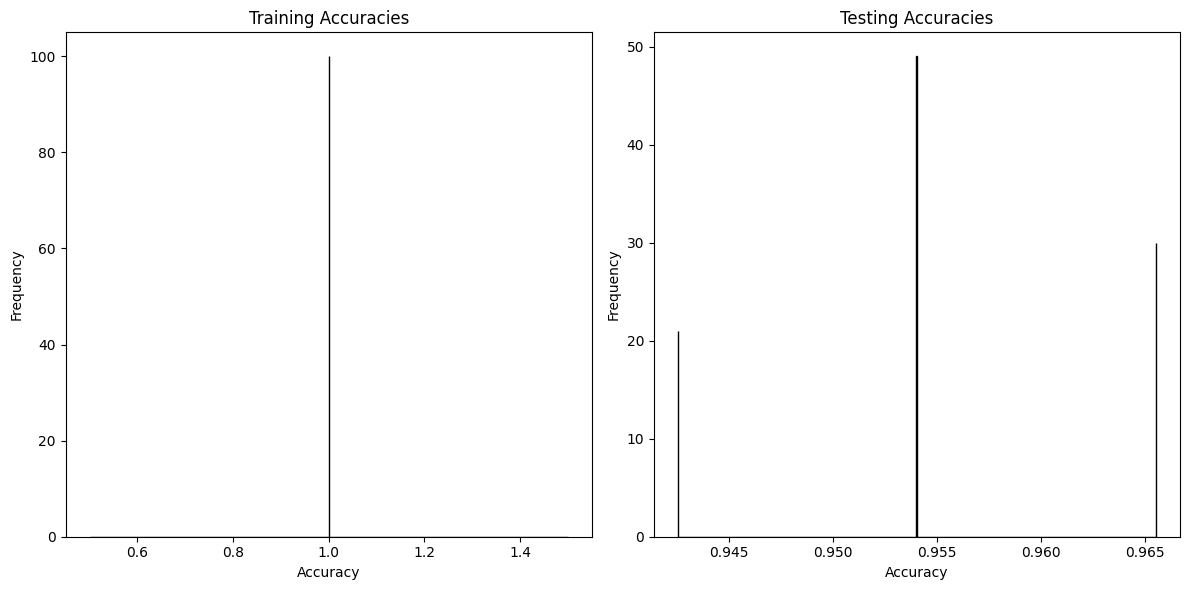

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(accuracies_train, bins=1000, color='skyblue', edgecolor='black')
axs[0].set_title('Training Accuracies')
axs[0].set_xlabel('Accuracy')
axs[0].set_ylabel('Frequency')

axs[1].hist(accuracies_test, bins=1000, color='lightgreen', edgecolor='black')
axs[1].set_title('Testing Accuracies')
axs[1].set_xlabel('Accuracy')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
